This is the NYC-COVID-19 modeling project. We will try to use location data from foursquare.com to predict COVID-19 cases in NYC neighborhoods. We will attempt linear regression, polynomial regression, and evaluate the model.

In [4]:
#Importing necessary packages
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


In [5]:
#pull neighborhoods coordinates from NYU. This data will only be used to query data from foursquare
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
#Will import all venues data (up to 277 venues per neighberhood.)
CLIENT_ID = 'LQSXBXBUX2VXVN3KVBATT2JNVXFT5BVW0MXXUPUUA4XD4SOT' # your Foursquare ID
CLIENT_SECRET = 'FFY20OCADMOVZONF0K3F0KZ1YCGJOIB5RBU3MCVACHMBZSZ3' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
LIMIT=277
nyc_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Your credentails:
CLIENT_ID: LQSXBXBUX2VXVN3KVBATT2JNVXFT5BVW0MXXUPUUA4XD4SOT
CLIENT_SECRET:FFY20OCADMOVZONF0K3F0KZ1YCGJOIB5RBU3MCVACHMBZSZ3
Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
P

In [7]:
print(nyc_venues.shape)

(9902, 7)


In [8]:
nyc_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In the following section, we will use a function to determine if a specific venue is within the boundry of a MODZCTA (a NYC health modified zip code system, that have been used to track COVID cases)

In [9]:
def IsPtInPoly(aLon, aLat, pointList):
    '''
    :param aLon: double 经度
    :param aLat: double 纬度
    :param pointList: list [(lon, lat)...] 多边形点的顺序需根据顺时针或逆时针，不能乱
    '''
    
    iSum = 0
    iCount = len(pointList)
    
    if(iCount < 3):
        return False
    
    
    for i in range(iCount):
        
        pLon1 = pointList[i][0]
        pLat1 = pointList[i][1]
        
        if(i == iCount - 1):
            
            pLon2 = pointList[0][0]
            pLat2 = pointList[0][1]
        else:
            pLon2 = pointList[i + 1][0]
            pLat2 = pointList[i + 1][1]
        
        if ((aLat >= pLat1) and (aLat < pLat2)) or ((aLat>=pLat2) and (aLat < pLat1)):
            
            if (abs(pLat1 - pLat2) > 0):
                
                pLon = pLon1 - ((pLon1 - pLon2) * (pLat1 - aLat)) / (pLat1 - pLat2);
                
                if(pLon < aLon):
                    iSum += 1
 
    if(iSum % 2 != 0):
        return True
    else:
        return False

In [10]:
#Let's import MODZCTA boundry data
with open('MODZCTA_2010_WGS1984.geo.json') as json_data:
    MODZCTA = json.load(json_data)
column_names = ['postcode', 'coordinates']
postcode_boundry=pd.DataFrame(columns=column_names)
for data in MODZCTA['features']:
    postcode = data['properties']['MODZCTA']
    coordinates = data['geometry']['coordinates']
    postcode_boundry=postcode_boundry.append({'postcode': postcode,
                                             'coordinates': coordinates}, ignore_index=True)
postcode_boundry.head()
    

,postcode,coordinates
0,10001,"[[[-73.987744, 40.744066], [-73.985044, 40.747..."
1,10002,"[[[-73.997504, 40.714071], [-73.997302, 40.713..."
2,10003,"[[[-73.988636, 40.722931], [-73.988434, 40.723..."
3,10004,"[[[[-74.008267, 40.70772], [-74.008007, 40.707..."
4,10005,"[[[-74.007826, 40.703087], [-74.006189, 40.704..."


In [11]:
for index in postcode_boundry.index:
    postcode_boundry.loc[index,'coordinates']=postcode_boundry.loc[index,'coordinates'][0]

In [12]:
postcode_boundry.head()

,postcode,coordinates
0,10001,"[[-73.987744, 40.744066], [-73.985044, 40.7477..."
1,10002,"[[-73.997504, 40.714071], [-73.997302, 40.7134..."
2,10003,"[[-73.988636, 40.722931], [-73.988434, 40.7232..."
3,10004,"[[[-74.008267, 40.70772], [-74.008007, 40.7079..."
4,10005,"[[-74.007826, 40.703087], [-74.006189, 40.7041..."


In [13]:
#Looks like we need to modify the boundry for 10004, and there may be more.
a = list()
for index in postcode_boundry.index:
    if len(postcode_boundry.loc[index,'coordinates'])==1:
        a.append(index)
for index in a:
    postcode_boundry.loc[index,'coordinates']=postcode_boundry.loc[index,'coordinates'][0]

In [14]:
postcode_boundry.head()

,postcode,coordinates
0,10001,"[[-73.987744, 40.744066], [-73.985044, 40.7477..."
1,10002,"[[-73.997504, 40.714071], [-73.997302, 40.7134..."
2,10003,"[[-73.988636, 40.722931], [-73.988434, 40.7232..."
3,10004,"[[-74.008267, 40.70772], [-74.008007, 40.70797..."
4,10005,"[[-74.007826, 40.703087], [-74.006189, 40.7041..."


In [15]:
#Let's try to eliminate any duplicate rows in postcode_boundry.
print(postcode_boundry.shape)
postcode_boundry=postcode_boundry.drop_duplicates(['postcode'])
print(postcode_boundry.shape)

(178, 2)
(178, 2)


In [16]:
#Let's test the IsPtInPoly function. I picked a point from google map that will for sure within the boundry of 10001
IsPtInPoly(-73.990352, 40.747121, postcode_boundry['coordinates'][0])

True

In [17]:
for i in nyc_venues.index:
    for j in postcode_boundry.index:
        if IsPtInPoly(nyc_venues.loc[i,'Venue Longitude'], nyc_venues.loc[i,'Venue Latitude'], postcode_boundry.loc[j,'coordinates']):
            nyc_venues.loc[i,'MODZCTA'] = postcode_boundry.loc[j,'postcode']

In [18]:
#Now that we have inserted MODZCTA into nyc_venues, next step we will have to delete any venues that do not have a MODZCTA assigned
print(nyc_venues.shape)
nyc_venues_nona=nyc_venues.dropna(subset=['MODZCTA'], how='any', axis=0)
print(nyc_venues_nona.shape)

(9902, 8)
(8749, 8)


In [19]:
#Let's do one hot coding for NYC venues
nyc_onehot = pd.get_dummies(nyc_venues_nona[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# add neighborhood column back to dataframe
nyc_onehot['MODZCTA'] = nyc_venues['MODZCTA'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]
nyc_onehot.head()

,MODZCTA,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10466,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#We won't use 'mean' here, instead, we will use sum. I believe the total number of a kind of venue matters more in epidemiology.
nyc_grouped = nyc_onehot.groupby('MODZCTA').sum().reset_index()
nyc_grouped

,MODZCTA,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,10002,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,1,0,1,2
2,10003,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2,0,0,1
3,10004,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10005,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,11691,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,11692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
153,11693,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,11694,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [22]:
#Let's read the COVID-19 case numbers
COVID=pd.read_csv('tests-by-zcta-5-13.csv')
COVID=COVID.dropna(subset=['MODZCTA'],how='any',axis=0)

In [23]:
#Let's merge the two dataframe
COVID[['MODZCTA']] = COVID[['MODZCTA']].astype(int)
nyc_grouped[['MODZCTA']] = nyc_grouped[['MODZCTA']].astype(int)
merged=pd.merge(nyc_grouped,COVID)

Now let's attempt a linear regression. 
In order for linear regression to work, we need to combine the venue category into 7 big groups. Because 412 elements entering linear regression will cause overfitting for sure. I have get the category tree from foursquare, so that we can combine 412 categories into 7 groups.

In [24]:
nyc_venues_nona.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,MODZCTA
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,10466
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,10466
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,10466
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,10466
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,10466


In [25]:
def combine_group(CSV_file, group):
    tree=pd.read_csv(CSV_file)
    for index in nyc_venues_nona.index:
        if nyc_venues_nona.loc[index,'Venue Category'] in list(tree[group]):
            nyc_venues_nona.loc[index,'Group'] = group

In [26]:
combine_group('food.csv', 'Food')
combine_group('College_University.csv', 'College & University')
combine_group('Event.csv', 'Event')
combine_group('Arts_Entertainment.csv', 'Arts & Entertainment')
combine_group('Nightlife Spot.csv', 'Nightlife Spot')
combine_group('Outdoors_Recreation.csv', 'Outdoors & Recreation')
combine_group('Professional_Other_Places.csv', 'Professional & Other Places')
combine_group('Shop_Service.csv', 'Shop & Service')
combine_group('Travel_Transport.csv', 'Travel & Transport')
combine_group('Residence.csv', 'Residence')

D:\Python\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Python\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
nyc_venues_nona

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,MODZCTA,Group
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,10466,Food
1,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,10466,Food
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,10466,Shop & Service
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,10466,Shop & Service
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,10466,Food
...,...,...,...,...,...,...,...,...,...
9897,Queensbridge,40.756091,-73.945631,The Ravel Hotel Gym,40.753787,-73.948815,Athletics & Sports,11101,Outdoors & Recreation
9898,Queensbridge,40.756091,-73.945631,Track 114,40.753008,-73.947833,Platform,11101,Travel & Transport
9899,Fox Hills,40.617311,-74.081740,SUBWAY,40.618939,-74.082881,Sandwich Place,10304,Food
9900,Fox Hills,40.617311,-74.081740,MTA Bus - Targee St & Vanderbilt Av (S74/S76),40.614856,-74.084598,Bus Stop,10304,Travel & Transport


In [28]:
# one hot encoding
nyc_onehot_group = pd.get_dummies(nyc_venues_nona[['Group']], prefix="", prefix_sep="")

In [29]:
nyc_onehot_group['MODZCTA'] = nyc_venues_nona['MODZCTA'] 

In [30]:
nyc_grouped_group = nyc_onehot_group.groupby('MODZCTA').sum().reset_index()
nyc_grouped_group

,MODZCTA,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,10001,5,0,43,8,10,1,0,15,4
1,10002,13,0,99,12,6,1,0,24,5
2,10003,5,0,62,4,10,0,0,25,1
3,10004,0,0,2,0,0,0,0,0,0
4,10005,1,0,17,0,4,3,0,3,1
...,...,...,...,...,...,...,...,...,...,...
151,11691,0,0,24,0,7,0,0,9,6
152,11692,0,0,6,0,9,1,0,2,4
153,11693,0,0,12,0,9,0,0,1,5
154,11694,0,0,47,6,17,0,0,13,2


In [31]:
nyc_grouped_group[['MODZCTA']] = nyc_grouped_group[['MODZCTA']].astype(int)
merged_group=pd.merge(nyc_grouped_group,COVID)

In [32]:
merged_group.head()

,MODZCTA,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Positive,Total,zcta_cum.perc_pos,High_disease_burden
0,10001,5,0,43,8,10,1,0,15,4,321,1176,27.30,0
1,10002,13,0,99,12,6,1,0,24,5,934,2513,37.17,0
2,10003,5,0,62,4,10,0,0,25,1,420,1602,26.22,0
3,10004,0,0,2,0,0,0,0,0,0,28,110,25.45,0
4,10005,1,0,17,0,4,3,0,3,1,54,266,20.30,0


In [33]:
Z_group=merged_group.iloc[:,1:10]
Z_group.head

<bound method NDFrame.head of      Arts & Entertainment  College & University  Food  Nightlife Spot  \
0                       5                     0    43               8   
1                      13                     0    99              12   
2                       5                     0    62               4   
3                       0                     0     2               0   
4                       1                     0    17               0   
..                    ...                   ...   ...             ...   
151                     0                     0    24               0   
152                     0                     0     6               0   
153                     0                     0    12               0   
154                     0                     0    47               6   
155                     0                     0     3               0   

     Outdoors & Recreation  Professional & Other Places  Residence  \
0                      

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
Z_group_train, Z_group_test, Y_group_train, Y_group_test = train_test_split(Z_group, merged_group['Positive'], test_size=0.1, random_state=1)
print('number of test samples:', Z_group_test.shape[0])
print('number of training samples:', Z_group_train.shape[0])
np.shape(Y_group_train)

number of test samples: 16
number of training samples: 140


(140,)

In [35]:
linear=LinearRegression()
linear.fit(Z_group_train, Y_group_train)
print('The R2 score for training set is:' ,linear.score(Z_group_train, Y_group_train))
print('The R2 score for testing set is:' , linear.score(Z_group_test, Y_group_test))

The R2 score for training set is: 0.22618046235872502
The R2 score for testing set is: 0.1850788524509268


In [36]:
from sklearn.model_selection import cross_val_score
Rcross = cross_val_score(linear, Z_group, merged_group['Positive'], cv=10)
print('Cross Validation mean R2 score is:', Rcross.mean())

Cross Validation mean R2 score is: -1.341547269095712


In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 12
    height = 10
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('COVID-19 case number')
    plt.ylabel('Proportion of MODZCTAs')

    plt.show()
    plt.close()

In [38]:
Zhat_group_test=linear.predict(Z_group_test)

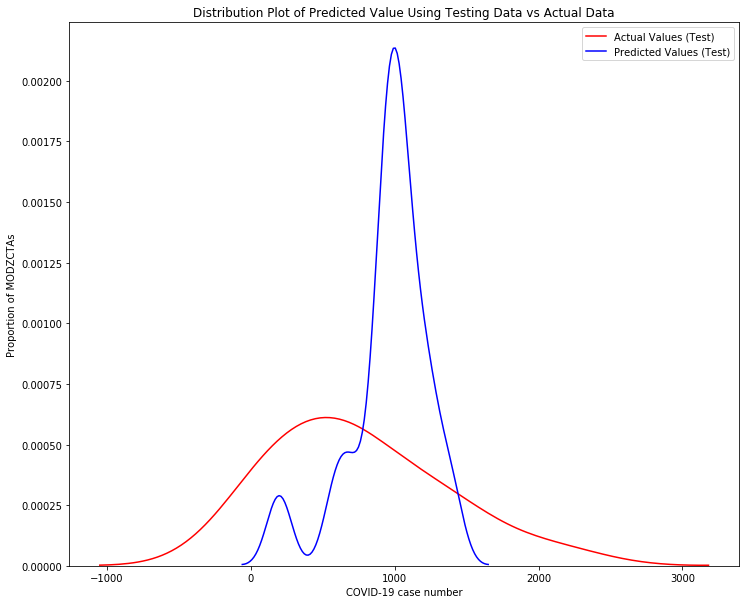

In [120]:
Title = 'Distribution Plot of Predicted Value Using Testing Data vs Actual Data'
DistributionPlot(Y_group_test, Zhat_group_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

Therefore linear regression is not a good model.
Let's try polynomial regression.

In [40]:
from sklearn.preprocessing import PolynomialFeatures
pr=PolynomialFeatures(degree=2)
Z_group_pr=pr.fit_transform(Z_group)
print(Z_group_pr.shape)

(156, 55)


In [41]:
Z_group_pr_train, Z_group_pr_test, Y_group_pr_train, Y_group_pr_test = train_test_split(Z_group_pr, merged_group['Positive'], test_size=0.1, random_state=1)

In [42]:
Poly=LinearRegression()
Poly.fit(Z_group_pr_train, Y_group_pr_train)
print('The R2 score for polynomial training set is:' ,Poly.score(Z_group_pr_train, Y_group_pr_train))
print('The R2 score for polynomial testing set is:' , Poly.score(Z_group_pr_test, Y_group_pr_test))

The R2 score for polynomial training set is: -21.393184431574024
The R2 score for polynomial testing set is: -61.71155971078568


In [43]:
Rcross = cross_val_score(Poly, Z_group_pr, merged_group['Positive'], cv=10)
print('Cross Validation polynomial regression mean R2 score is:', Rcross.mean())

Cross Validation polynomial regression mean R2 score is: -34.885755884337335


In [44]:
Zhat_group_pr_test=Poly.predict(Z_group_pr_test)

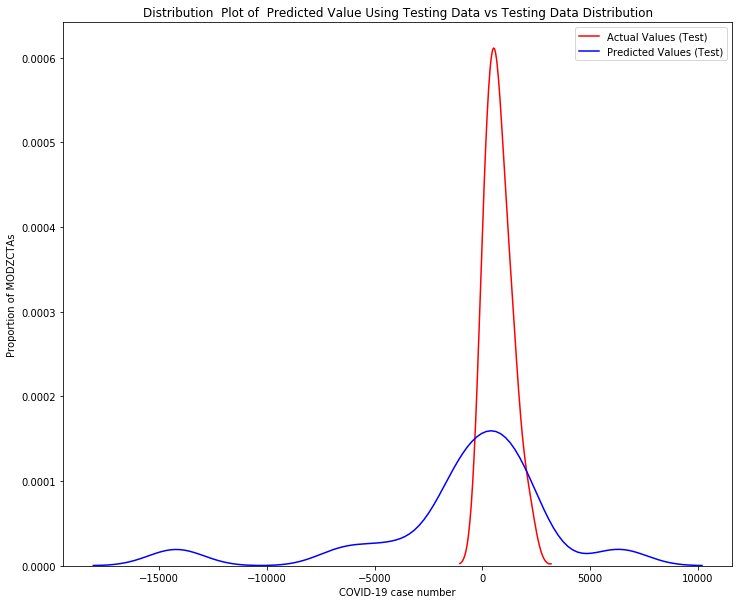

In [45]:
Title = 'Distribution  Plot of  Predicted Value Using Testing Data vs Testing Data Distribution'
DistributionPlot(Y_group_pr_test, Zhat_group_pr_test, "Actual Values (Test)", "Predicted Values (Test)", Title)

Therefore polynomial regression is not an ideal model.
As above, we have tried two models, and it appears that venue category is not a good predictor for COVID-19 case number.

We are going to try neural network selector.

In [46]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues_nona[['Venue Category']], prefix="", prefix_sep="")

In [47]:
nyc_onehot['MODZCTA'] = nyc_venues_nona['MODZCTA'] 

In [48]:
nyc_grouped = nyc_onehot.groupby('MODZCTA').sum().reset_index()
nyc_grouped

,MODZCTA,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,10002,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,1,0,1,2
2,10003,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,2,0,0,1
3,10004,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10005,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,11691,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,11692,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
153,11693,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,11694,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [56]:
nyc_grouped[['MODZCTA']] = nyc_grouped[['MODZCTA']].astype(int)
merged=pd.merge(nyc_grouped,COVID)

In [63]:
merged.head()

,MODZCTA,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Positive,Total,zcta_cum.perc_pos,High_disease_burden
0,10001,0,0,0,0,0,2,0,0,0,...,0,1,0,0,0,1,321,1176,27.30,0
1,10002,0,0,0,0,0,4,0,0,0,...,0,0,1,0,1,2,934,2513,37.17,0
2,10003,0,0,0,0,0,1,0,0,0,...,0,1,2,0,0,1,420,1602,26.22,0
3,10004,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,28,110,25.45,0
4,10005,0,0,0,0,0,3,0,0,0,...,0,0,1,0,0,0,54,266,20.30,0


In [58]:
merged.shape

(156, 417)

In [62]:
Z=merged.iloc[:,1:-4]
Z.head

<bound method NDFrame.head of      Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                    0               0                  0                   0   
1                    0               0                  0                   0   
2                    0               0                  0                   0   
3                    0               0                  0                   0   
4                    0               0                  0                   0   
..                 ...             ...                ...                 ...   
151                  0               0                  0                   0   
152                  0               0                  0                   0   
153                  0               0                  0                   0   
154                  0               0                  0                   0   
155                  0               0                  0                   0  

In [64]:
Z_train, Z_test, Y_train, Y_test = train_test_split(Z, merged["High_disease_burden"], test_size=0.2, random_state=0)

In [65]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Z_train) 
Z_train = scaler.transform(Z_train) 
 # apply same transformation to test data
Z_test = scaler.transform(Z_test)  

In [67]:
clf.fit(Z_train, Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [69]:
clf.score(Z_test, Y_test)

0.6875

In [99]:
scores = cross_val_score(clf, Z, merged["High_disease_burden"], cv=5, scoring='accuracy')
scores.mean()

0.7491935483870967

In [124]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, Z, merged["High_disease_burden"],scoring=scoring, cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

[0.875      0.80645161 0.74193548 0.67741935 0.64516129] 0.7491935483870967 [0.71428571 0.72321429 0.58035714 0.58928571 0.56845238] 0.6351190476190476 [0.93103448 0.72321429 0.60384615 0.57575758 0.5547619 ] 0.6777228805677081 [0.76296296 0.72321429 0.58666667 0.57880435 0.55424837] 0.6411793258366147


Let's adjust alpha and test again.

In [80]:
clf2 = MLPClassifier(solver='lbfgs', alpha=0.01,
                    hidden_layer_sizes=(5, 2), random_state=1)

In [97]:
scores = cross_val_score(clf2, Z, merged["High_disease_burden"], cv=5)
scores

array([0.84375   , 0.77419355, 0.74193548, 0.67741935, 0.67741935])

In [125]:
scores = cross_validate(clf2, Z, merged["High_disease_burden"],scoring=scoring, cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

[0.84375    0.77419355 0.74193548 0.67741935 0.67741935] 0.7429435483870968 [0.69428571 0.60119048 0.63095238 0.58928571 0.58928571] 0.621 [0.80357143 0.65740741 0.63095238 0.57575758 0.57575758] 0.6486892736892736 [0.72555746 0.61319073 0.63095238 0.57880435 0.57880435] 0.6254618537697725


Let's see the dummy selector performance.

In [126]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
scoring = ['accuracy','precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(dummy_clf, Z, merged["High_disease_burden"], scoring=scoring,
                         cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

[0.78125    0.77419355 0.77419355 0.77419355 0.77419355] 0.7756048387096774 [0.5 0.5 0.5 0.5 0.5] 0.5 [0.390625   0.38709677 0.38709677 0.38709677 0.38709677] 0.3878024193548387 [0.43859649 0.43636364 0.43636364 0.43636364 0.43636364] 0.4368102073365231


D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
scores = cross_val_score(dummy_clf, Z, merged["High_disease_burden"], cv=10, scoring='accuracy')
scores

array([0.8125, 0.75  , 0.75  , 0.75  , 0.75  , 0.75  , 0.8   , 0.8   ,
       0.8   , 0.8   ])

Above, we have tried neuronetwork. We are going to try more methods.

SVM:

In [139]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
param_grid = {'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], 'gamma':[0.001, 0.0001]}
grid_search = GridSearchCV(model, param_grid, n_jobs = 1, verbose =1)
grid_search.fit(Z_train, Y_train)
best_parameters = grid_search.best_estimator_.get_params()
for para, val in list (best_parameters.items()):
    print(para, val)
SVC_model = SVC(kernel='rbf', C=best_parameters['C'], gamma=best_parameters['gamma'], probability=True)
scoring = ['precision_macro', 'recall_macro', 'f1_macro', 'accuracy']
scores = cross_validate(SVC_model, Z, merged["High_disease_burden"],scoring=scoring, cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    1.9s finished
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

C 10
break_ties False
cache_size 200
class_weight None
coef0 0.0
decision_function_shape ovr
degree 3
gamma 0.0001
kernel rbf
max_iter -1
probability True
random_state None
shrinking True
tol 0.001
verbose False
[0.78125    0.77419355 0.77419355 0.77419355 0.77419355] 0.7756048387096774 [0.5 0.5 0.5 0.5 0.5] 0.5 [0.390625   0.38709677 0.38709677 0.38709677 0.38709677] 0.3878024193548387 [0.43859649 0.43636364 0.43636364 0.43636364 0.43636364] 0.4368102073365231


D:\Python\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let's try random forest.

In [136]:
from sklearn.ensemble import RandomForestClassifier
Ranfo=RandomForestClassifier()
scores = cross_validate(Ranfo, Z, merged["High_disease_burden"],scoring=scoring, cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

[0.8125     0.83870968 0.83870968 0.80645161 0.77419355] 0.8141129032258065 [0.57142857 0.69345238 0.64285714 0.57142857 0.55059524] 0.6059523809523809 [0.90322581 0.80092593 0.9137931  0.9        0.64655172] 0.832899311992749 [0.57142857 0.72370766 0.67505241 0.56944444 0.54507338] 0.6169412933841347


Let's try gradient boosting decision tree.

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
GBDT=GradientBoostingClassifier()
scores = cross_validate(Ranfo, Z, merged["High_disease_burden"],scoring=scoring, cv=5)
print(scores['test_accuracy'],scores['test_accuracy'].mean(),scores['test_recall_macro'],scores['test_recall_macro'].mean(),scores['test_precision_macro'],scores['test_precision_macro'].mean(),scores['test_f1_macro'],scores['test_f1_macro'].mean(),)

[0.8125     0.83870968 0.83870968 0.80645161 0.83870968] 0.8270161290322582 [0.57142857 0.64285714 0.64285714 0.57142857 0.64285714] 0.6142857142857142 [0.90322581 0.9137931  0.9137931  0.9        0.9137931 ] 0.9089210233592879 [0.57142857 0.67505241 0.67505241 0.56944444 0.67505241] 0.6332060497154837
